In [1]:
import pandas as pd
import numpy as np
import json
import os,sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

https://github.com/google-research/google-research/tree/master/group_agnostic_fairness/data_utils

In [15]:
temp_df = pd.read_csv('../data/compas-scores-two-years.csv')

In [16]:
temp_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [17]:
temp_df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [23]:
columns = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'age', 
                'c_charge_degree', 
#                 'c_charge_desc',
                'sex', 'race',  'is_recid']
target_variable = 'is_recid'
target_value = 'Yes'

# Drop duplicates
temp_df = temp_df[['id']+columns].drop_duplicates()
df = temp_df[columns].copy()

# Convert columns of type ``object`` to ``category`` 
# df = pd.concat([
#         df.select_dtypes(include=[], exclude=['object']),
#         df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
#         ], axis=1).reindex_axis(df.columns, axis=1)

# Binarize target_variable
df['is_recid'] = df.apply(lambda x: 'Yes' if x['is_recid']==1.0 else 'No', axis=1).astype('category')

# Process protected-column values
race_dict = {'African-American':'Black','Caucasian':'White'}
df['race'] = df.apply(lambda x: race_dict[x['race']] if x['race'] in race_dict.keys() else 'Other', axis=1).astype('category')

In [24]:
df.head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age,c_charge_degree,sex,race,is_recid
0,0,0,0,0,69,F,Male,Other,No
1,0,0,0,0,34,F,Male,Black,Yes
2,0,0,1,4,24,F,Male,Black,Yes
3,0,1,0,1,23,F,Male,Black,No
4,0,0,0,2,43,F,Male,Other,No


In [25]:
print(df['c_charge_degree'].unique())
# print(df['c_charge_desc'].unique())
# print(df['age_cat'].unique())
print(df['sex'].unique())
print(df['race'].unique())
print(df['is_recid'].unique())

['F' 'M']
['Male' 'Female']
[Other, Black, White]
Categories (3, object): [Other, Black, White]
[No, Yes]
Categories (2, object): [No, Yes]


In [27]:
df_proc = df.copy()
race_map = {'Black':1.0,'White':0.0,'Other':2.0}
sex_map = {'Female':1.0,'Male':0.0}
ccd_map = {'F':1.0,'M':0.0}
# age_map = {'Greater than 45':2.0, '25 - 45':1.0, 'Less than 25':0.0}
recid_map = {'Yes':1.0,'No':0.0}

df_proc['sex'] = df_proc.apply(lambda x: sex_map[x['sex']], axis=1)
df_proc['race'] = df_proc.apply(lambda x: race_map[x['race']], axis=1)
df_proc['is_recid'] = df_proc.apply(lambda x: recid_map[x['is_recid']], axis=1)
df_proc['c_charge_degree'] = df_proc.apply(lambda x: ccd_map[x['c_charge_degree']], axis=1)

In [28]:
df_proc.head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age,c_charge_degree,sex,race,is_recid
0,0,0,0,0,69,1.0,0.0,2.0,0.0
1,0,0,0,0,34,1.0,0.0,1.0,1.0
2,0,0,1,4,24,1.0,0.0,1.0,1.0
3,0,1,0,1,23,1.0,0.0,1.0,0.0
4,0,0,0,2,43,1.0,0.0,2.0,0.0


In [29]:
df_proc.to_csv('../data/compas_proc.csv')

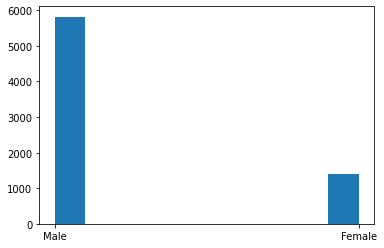

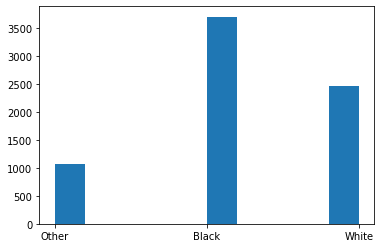

In [30]:
plt.hist(df['sex'])
plt.show()
plt.hist(df['race'])
plt.show()

In [1]:
from load_data import *

In [2]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_compas_data()

In [4]:
Xtr.shape

(5049, 7)

In [5]:
uniX = np.unique(Xtr,axis=0)
print(uniX.shape)

(5049, 7)
